In [2]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import matthews_corrcoef, mean_absolute_error, roc_curve, auc, roc_auc_score, recall_score, accuracy_score, classification_report, confusion_matrix, log_loss
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer, make_blobs
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from imblearn.over_sampling import SMOTE

import itertools
import os 
os.chdir('e:/ml_data/kaggle_data/mushroom')

In [3]:
os.listdir()

['sample_submission.csv', 'test.csv', 'train.csv']

In [3]:
train_data = pd.read_csv('./train.csv', index_col='id')
test_data = pd.read_csv('./test.csv', index_col='id')

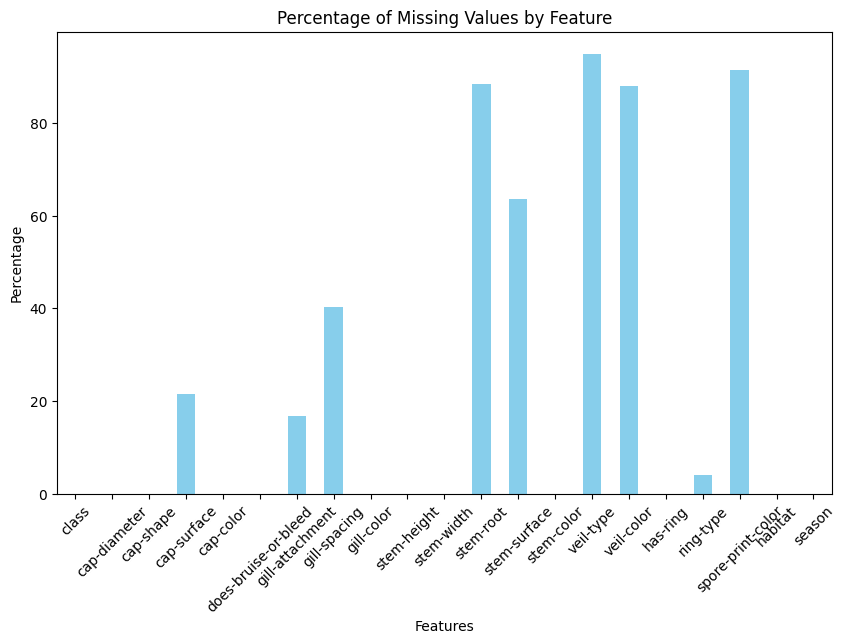

In [4]:
missing_values = train_data.isnull().mean() * 100
missing_values.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Percentage of Missing Values by Feature')
plt.ylabel('Percentage')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

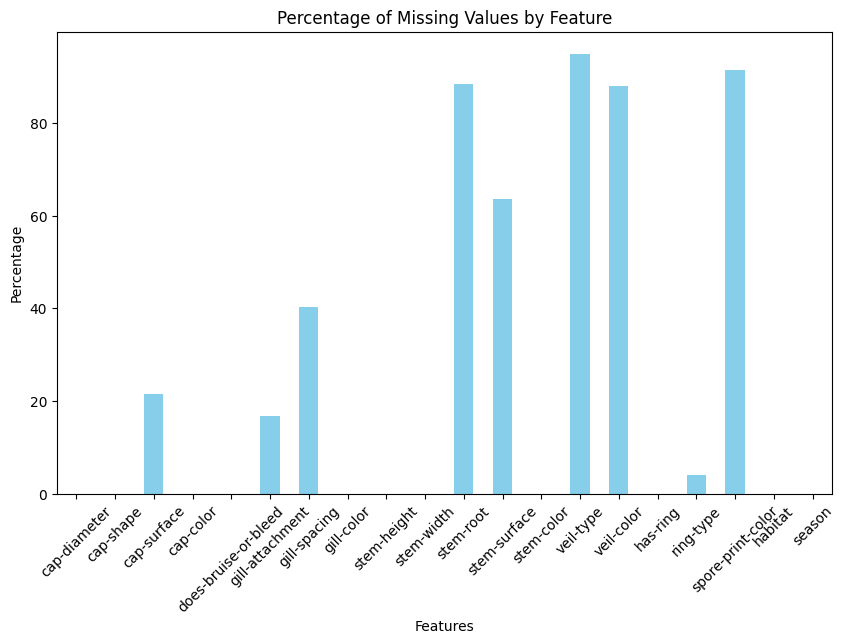

In [5]:
missing_values = test_data.isnull().mean() * 100

# Plot
missing_values.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Percentage of Missing Values by Feature')
plt.ylabel('Percentage')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

In [6]:
train_data.isna().mean().sort_values(ascending=False)

veil-type              0.949
spore-print-color      0.914
stem-root              0.885
veil-color             0.879
stem-surface           0.636
gill-spacing           0.404
cap-surface            0.215
gill-attachment        0.168
ring-type              0.041
gill-color             0.000
habitat                0.000
cap-shape              0.000
stem-color             0.000
has-ring               0.000
cap-color              0.000
does-bruise-or-bleed   0.000
cap-diameter           0.000
class                  0.000
stem-width             0.000
stem-height            0.000
season                 0.000
dtype: float64

In [7]:
near_empty_cols = train_data.isna().mean().sort_values(ascending=False)
near_empty_cols = [id for id in near_empty_cols.index if near_empty_cols[id] > 0.7] # collect nearly empty columns

In [8]:
train_data = train_data.drop(near_empty_cols, axis=1)
test_data = test_data.drop(near_empty_cols, axis=1)

In [92]:
near_empty_cols

['veil-type', 'spore-print-color', 'stem-root', 'veil-color']

In [9]:
train_data.shape

(3116945, 17)

In [10]:
train_data.isna().mean().sort_values(ascending=False)

stem-surface           0.636
gill-spacing           0.404
cap-surface            0.215
gill-attachment        0.168
ring-type              0.041
gill-color             0.000
habitat                0.000
cap-shape              0.000
stem-color             0.000
has-ring               0.000
cap-color              0.000
does-bruise-or-bleed   0.000
cap-diameter           0.000
class                  0.000
stem-width             0.000
stem-height            0.000
season                 0.000
dtype: float64

In [11]:
num_cols = train_data.select_dtypes(['float64']).columns
for data in [train_data, test_data]:
    data[num_cols] = data[num_cols].fillna(data[num_cols].median())
    

In [12]:
train_data[num_cols].median()

cap-diameter   5.750
stem-height    5.880
stem-width     9.650
dtype: float64

In [13]:
num_cols

Index(['cap-diameter', 'stem-height', 'stem-width'], dtype='object')

In [14]:
train_data.describe()

,cap-diameter,stem-height,stem-width
count,3116945.000,3116945.000,3116945.000
mean,6.310,6.348,11.154
std,4.658,2.700,8.095
min,0.030,0.000,0.000
25%,3.320,4.670,4.970
50%,5.750,5.880,9.650
75%,8.240,7.410,15.630
max,80.670,88.720,102.900


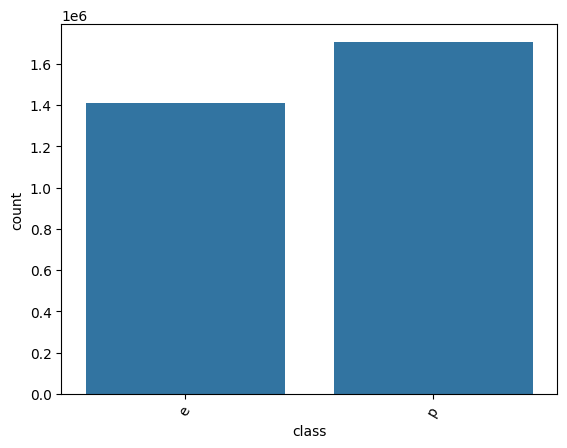

In [15]:
sns.countplot(x='class', data=train_data)
plt.xticks(rotation=60)
plt.show()

In [16]:
cat_cols = list(train_data.select_dtypes(['object']).columns.difference(['class']))

In [17]:
for col in cat_cols:
    mode_value = train_data[col].mode()[0]
    train_data[col].fillna(mode_value, inplace=True)

C:\Users\fxinw\AppData\Local\Temp\ipykernel_74956\1011155851.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna(mode_value, inplace=True)


In [18]:
train_data[cat_cols[3]].value_counts()

does-bruise-or-bleed
f           2569751
t            547085
w                14
c                11
h                 9
a                 7
b                 7
x                 7
y                 7
k                 6
s                 6
e                 4
l                 4
p                 4
d                 4
g                 3
z                 3
o                 3
i                 2
n                 2
r                 1
has-ring          1
3.43              1
4.42              1
2.9               1
u                 1
Name: count, dtype: int64

In [19]:
for col in cat_cols:
    mode_value = test_data[col].mode()[0]
    test_data[col].fillna(mode_value, inplace=True)


C:\Users\fxinw\AppData\Local\Temp\ipykernel_74956\2721510762.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data[col].fillna(mode_value, inplace=True)


In [20]:
or_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_data[cat_cols] = or_encoder.fit_transform(train_data[cat_cols])
test_data[cat_cols] = or_encoder.transform(test_data[cat_cols])

In [21]:
cat_cols

['cap-color',
 'cap-shape',
 'cap-surface',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-color',
 'gill-spacing',
 'habitat',
 'has-ring',
 'ring-type',
 'season',
 'stem-color',
 'stem-surface']

In [22]:
num_cols

Index(['cap-diameter', 'stem-height', 'stem-width'], dtype='object')

In [23]:
label_encoder = LabelEncoder()
train_data['class'] = label_encoder.fit_transform(train_data['class'])

In [24]:
cr_mat = train_data.corr()
target_cr = cr_mat['class'].sort_values(ascending=True)

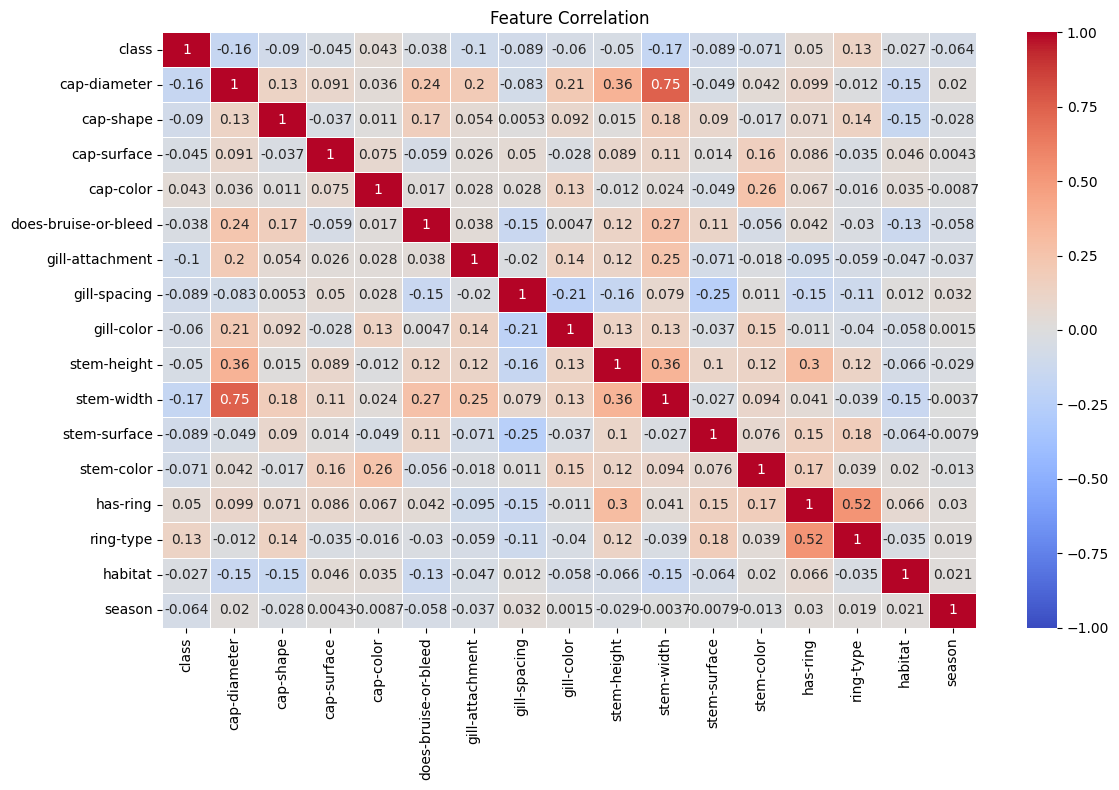

In [25]:
plt.figure(figsize=(12, 8))
sns.heatmap(cr_mat, annot=True, cmap='coolwarm', linewidths=.5, vmin=-1, vmax=1)
plt.title('Feature Correlation')
plt.tight_layout()
plt.show()

In [43]:
num_cols

Index(['cap-diameter', 'stem-height', 'stem-width'], dtype='object')

In [45]:
plt.subplots?

Signature:
plt.subplots(
    nrows: 'int' = 1,
    ncols: 'int' = 1,
    *,
    sharex: "bool | Literal['none', 'all', 'row', 'col']" = False,
    sharey: "bool | Literal['none', 'all', 'row', 'col']" = False,
    squeeze: 'bool' = True,
    width_ratios: 'Sequence[float] | None' = None,
    height_ratios: 'Sequence[float] | None' = None,
    subplot_kw: 'dict[str, Any] | None' = None,
    gridspec_kw: 'dict[str, Any] | None' = None,
    **fig_kw,
) -> 'tuple[Figure, Any]'
Docstring:
Create a figure and a set of subplots.

This utility wrapper makes it convenient to create common layouts of
subplots, including the enclosing figure object, in a single call.

Parameters
----------
nrows, ncols : int, default: 1
    Number of rows/columns of the subplot grid.

sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
    Controls sharing of properties among x (*sharex*) or y (*sharey*)
    axes:

    - True or 'all': x- or y-axis will be shared among all subplots.
    - False

In [ ]:
fig, axes = plt.subplots(1, 3)
for i, col in enumerate(num_cols):
    sns.distplot(train_data[col], ax=axes[i])
    sns.distplot(train_data[col].apply(np.log1p), ax=axes[i])
    axes[i].set_title(col)
plt.show()

C:\Users\fxinw\AppData\Local\Temp\ipykernel_74956\2190819798.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data[num_cols].apply(np.log1p)[num_cols[2]])


<Axes: xlabel='stem-width', ylabel='Density'>

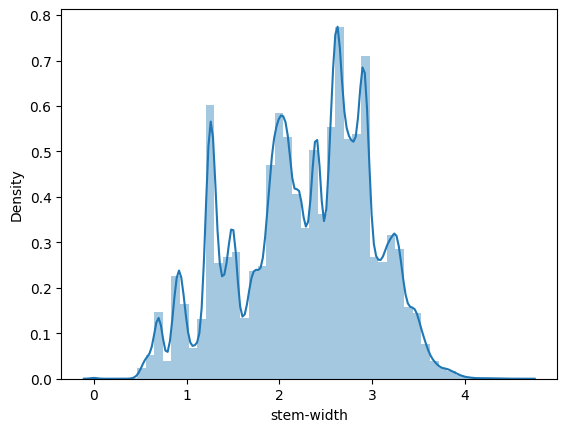

In [59]:
sns.distplot(train_data[num_cols].apply(np.log1p)[num_cols[2]])

In [61]:
for data in [train_data, test_data]:
    data[num_cols] = data[num_cols].apply(np.log1p)

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(train_data[cat_cols].corr(), annot=True)
plt.tight_layout()
plt.show()

In [71]:
X = train_data.drop(['class'], axis=1)
y = train_data['class']
X.shape, test_data.shape

((3116945, 16), (2077964, 16))

In [73]:
parameters1 = {'n_estimators': 939, 'max_depth': 10, 'learning_rate': 0.06544815748043165, 'subsample': 0.9610304725228028, 'colsample_bytree': 0.593829552078194, 'gamma': 2.1080218297443725e-07, 'lambda': 3.5015071752140682e-06, 'alpha': 3.0470355147783704e-06, 'scale_pos_weight': 1.0498998692005128}


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = XGBClassifier(**parameters1)
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mcc = matthews_corrcoef(y_test, y_pred)

In [98]:
def mcc_metric(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred = (y_pred > 0.5).astype(int) 
    mcc = matthews_corrcoef(y_true, y_pred)
    return 'mcc', mcc

In [111]:
y_test.value_counts()

class
1    340992
0    282397
Name: count, dtype: int64

In [114]:
X_test.shape, X_train.shape

((623389, 16), (2493556, 16))

In [94]:
def cnf_matrix_plotter(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)
    plt.title('Confsion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i,j] > threshold else 'black',
                 fontsize=25
                 )
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

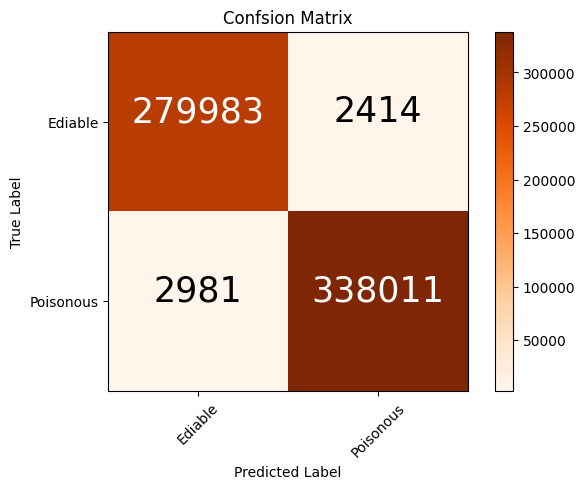

In [95]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
cnf_matrix_plotter(cm, ['Ediable', 'Poisonous'])

<Figure size 640x480 with 0 Axes>

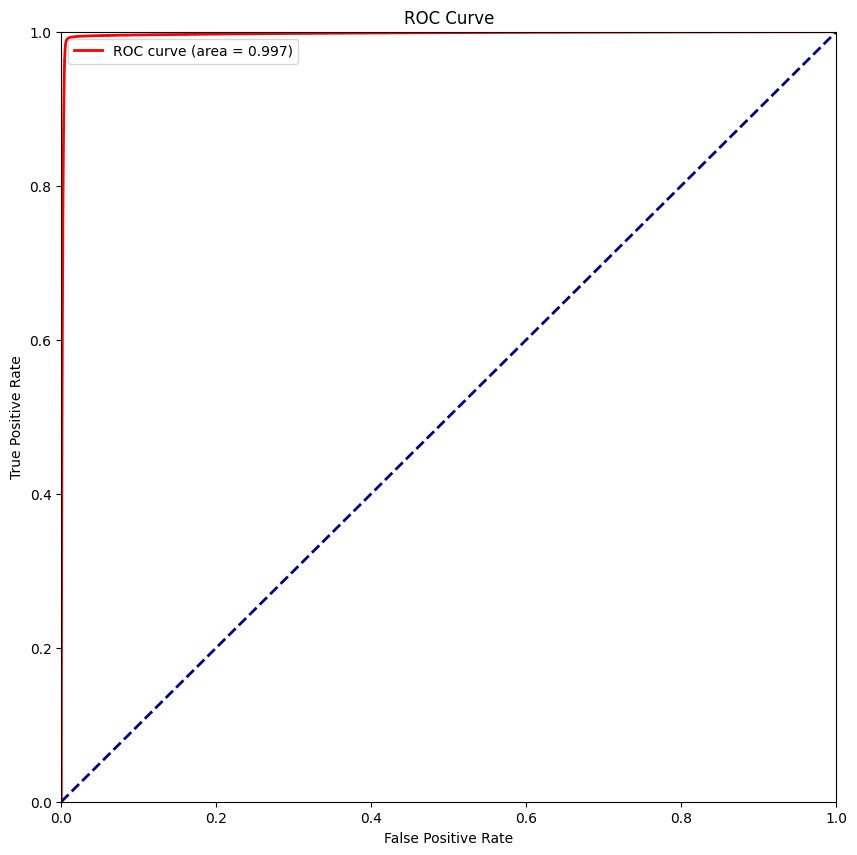

In [77]:
fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='r',
         lw=lw, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0., 1.])
plt.ylim([0., 1.])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [78]:
preds = model.predict(test_data)
predictions = label_encoder.inverse_transform(preds)

In [83]:
pd.DataFrame(preds).value_counts()

0
1    1133504
0     944460
Name: count, dtype: int64

In [33]:
submission = pd.DataFrame({'id': test_data.index, 'class': predictions})
submission.to_csv('submission.csv', index=False)
submission['class'].value_counts()

class
p    1133504
e     944460
Name: count, dtype: int64